In [1]:
import cv2
import imgaug as iaa
import numpy as np
import imgaug as iaa 
import glob
import os
from sklearn import metrics
from scipy.spatial import distance

In [2]:
def dice(pred, true, k = 255):
    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

def dice(true_mask, pred_mask, non_seg_score=1.0):
    """
        Computes the Dice coefficient.
        Args:
            true_mask : Array of arbitrary shape.
            pred_mask : Array with the same shape than true_mask.  
        
        Returns:
            A scalar representing the Dice coefficient between the two segmentations. 
        
    """
    assert true_mask.shape == pred_mask.shape

    true_mask = np.asarray(true_mask).astype(np.bool)
    pred_mask = np.asarray(pred_mask).astype(np.bool)

    # If both segmentations are all zero, the dice will be 1. (Developer decision)
    im_sum = true_mask.sum() + pred_mask.sum()
    if im_sum == 0:
        return non_seg_score

    # Compute Dice coefficient
    intersection = np.logical_and(true_mask, pred_mask)
    return 2. * intersection.sum() / im_sum

In [3]:
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    return (2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin))

def mean_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (n_samples, height, width, n_channels)
    batch_size = y_true.shape[0]
    channel_num = y_true.shape[-1]
    mean_dice_channel = 0.
    for i in range(batch_size):
        for j in range(channel_num):
            channel_dice = single_dice_coef(y_true[i, :, :, j], y_pred_bin[i, :, :, j])
            mean_dice_channel += channel_dice/(channel_num*batch_size)
    return mean_dice_channel

def dice_coef2(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    if union==0: return 1
    intersection = np.sum(y_true_f * y_pred_f)
    return 2. * intersection / union


In [4]:
def adjust_pixels(src, tolerancy):

    # convert to binary by thresholding
    ret, binary_map = cv2.threshold(src,127,255,0)

    # do connected components processing
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_map, None, None, None, 8, cv2.CV_32S)

    #get CC_STAT_AREA component as stats[label, COLUMN] 
    areas = stats[1:,cv2.CC_STAT_AREA]

    result = np.zeros((labels.shape), np.uint8)

    for i in range(0, nlabels - 1):
        if areas[i] >= tolerancy:   #keep
            result[labels == i + 1] = 255
            
    return result

In [5]:
def ellipse_overlap(image, x_center, y_center, length_x, length_y, angle=0, color=(255,255,255), thickness=-1):
    """
    funcao para sobrepor o pixel de uma determinada coordenada por uma elipse.
    entrada: image - array que define a imagem
             x_center -  posicao do eixo x onde o pixel se encontra 
             y_center -  posicao do eixo y onde o pixel se encontra 
             length_x -  comprimento da elipse ao longo do eixo x
             length_y -  comprimento da elipse ao longo do eixo y
             angle    -  angulo que a elipse possui
             color    -  cor da elipse
             thickness-  tipo de preenchimento, -1 preenche totalmente
    saida:
             array com a elipse na posicao determinada inserida na imagem de entrada
    """
    center_coordinates = (y_center, x_center)
    axesLength = (length_x, length_y)  
    angle = angle
    startAngle = 180
    endAngle = 540
    
    # Cor de preenchimento da elipse
    color = color

    # Metodo de preenchimento, -1 preenche totalmente
    thickness = thickness

    image = cv2.ellipse(image, center_coordinates, axesLength, angle,
                              startAngle, endAngle, color, thickness)
   
    return image


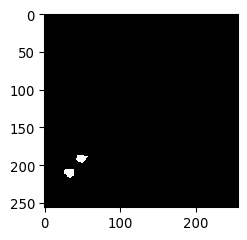

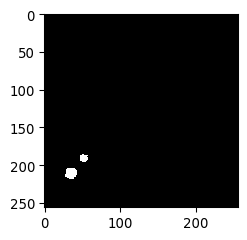

dice : 0.0026248575582537626
iou : 0.5030120481927711
precision : 0.7389380530973452


In [6]:
name_img = 'daninha_1536_19968'
img_t = cv2.imread('../../daninhas/ortomosaicos/pre-emergente/184514/marcacoes_manuais/' + name_img + '.png', 1)
img_t = cv2.cvtColor(img_t, cv2.COLOR_BGR2GRAY)

img_p = cv2.imread('../../daninhas/ortomosaicos/pre-emergente/184514/resultados_rede_manuais/' + name_img + '.png', 1)
img_p = cv2.cvtColor(img_p, cv2.COLOR_BGR2GRAY)
#img_p = adjust_pixels(img_p, 70)

coordinates_pixels_white = np.column_stack(np.where(img_p != [0]))
iaa.imshow(img_t)
for i in range(0, len(coordinates_pixels_white), 1):
    #print(coordinates_pixels_white[i])
    img_p = ellipse_overlap(img_p, coordinates_pixels_white[i][0], coordinates_pixels_white[i][1], 2, 1, 0)

iaa.imshow(img_p)
print('dice :', single_dice_coef(img_t, img_p))
print('iou :', metrics.jaccard_score(img_t, img_p, average='micro'))
print('precision :', metrics.recall_score(img_t, img_p, average='micro'))

Imagem RGB:


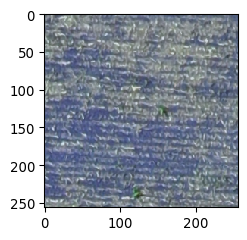

Referencia: 


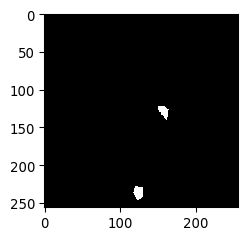

Predicao : 


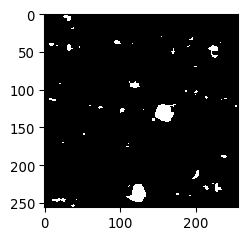

Predicao limpa com superpixels :


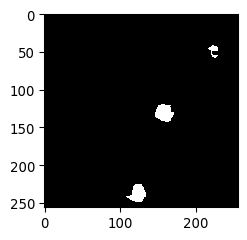

Predicao com Ajuste por elipse: 


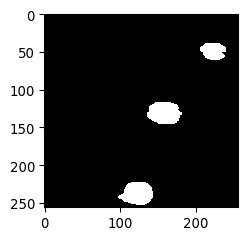

Acurácia:  0.67578125 , Indice de Jaccard : 0.1169 Coef de Dice 0.2094
--------------------------------------------------------------------------------------------------
Imagem RGB:


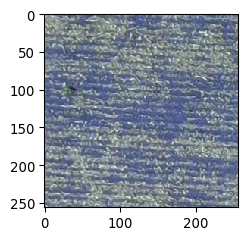

Referencia: 


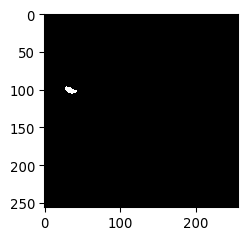

Predicao : 


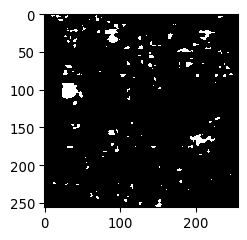

Predicao limpa com superpixels :


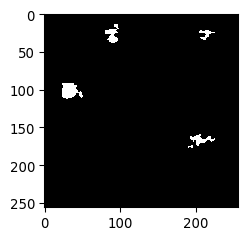

Predicao com Ajuste por elipse: 


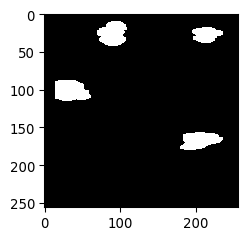

Acurácia:  0.67578125 , Indice de Jaccard : 0.0262 Coef de Dice 0.051
--------------------------------------------------------------------------------------------------
Imagem RGB:


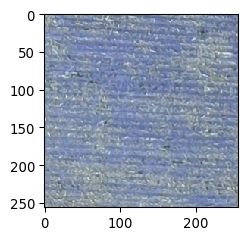

Referencia: 


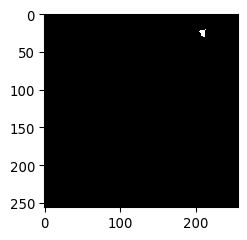

Predicao : 


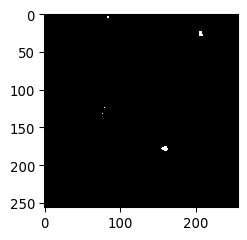

Predicao limpa com superpixels :


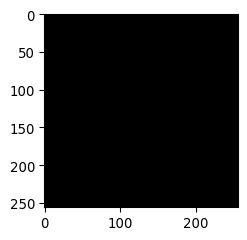

Predicao com Ajuste por elipse: 


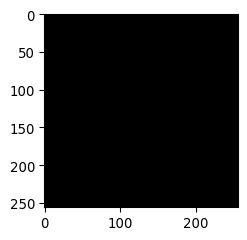

Acurácia:  0.95703125 , Indice de Jaccard : 0.0 Coef de Dice 0.0
--------------------------------------------------------------------------------------------------
Imagem RGB:


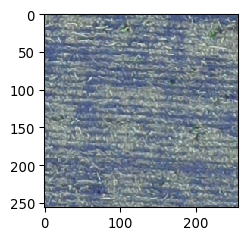

Referencia: 


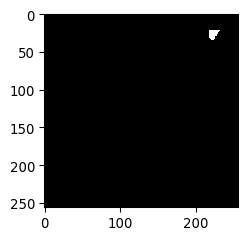

Predicao : 


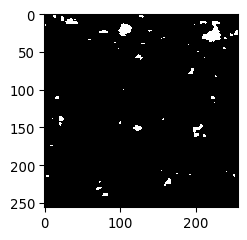

Predicao limpa com superpixels :


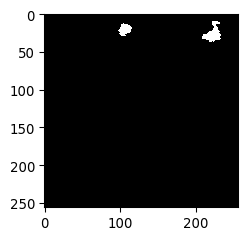

Predicao com Ajuste por elipse: 


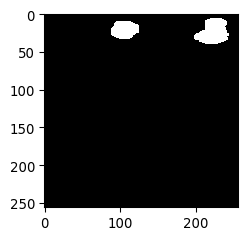

Acurácia:  0.8671875 , Indice de Jaccard : 0.0712 Coef de Dice 0.1329
--------------------------------------------------------------------------------------------------
Imagem RGB:


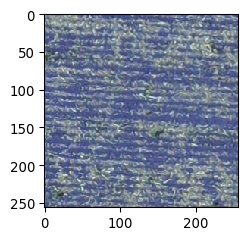

Referencia: 


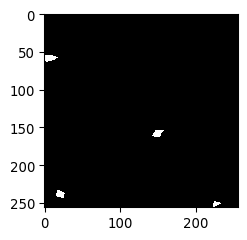

Predicao : 


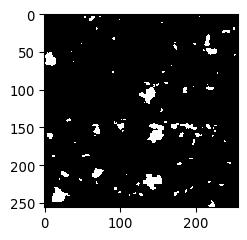

Predicao limpa com superpixels :


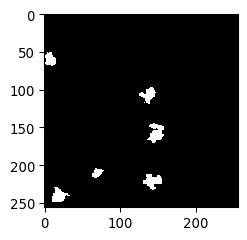

Predicao com Ajuste por elipse: 


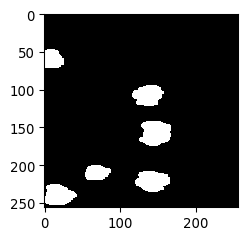

Acurácia:  0.44921875 , Indice de Jaccard : 0.0616 Coef de Dice 0.116
--------------------------------------------------------------------------------------------------
Imagem RGB:


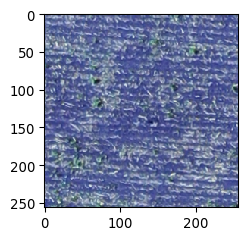

Referencia: 


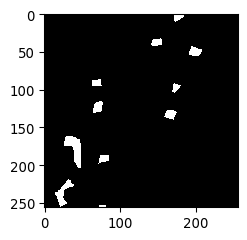

Predicao : 


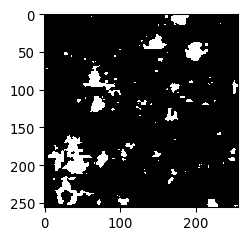

Predicao limpa com superpixels :


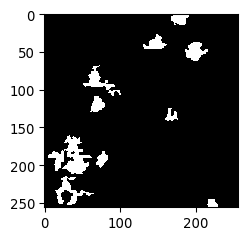

Predicao com Ajuste por elipse: 


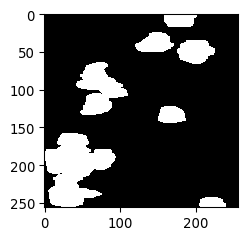

Acurácia:  0.07421875 , Indice de Jaccard : 0.1428 Coef de Dice 0.2499
--------------------------------------------------------------------------------------------------
Imagem RGB:


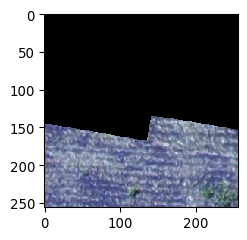

Referencia: 


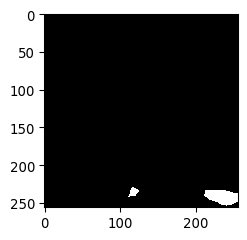

Predicao : 


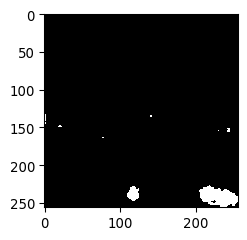

Predicao limpa com superpixels :


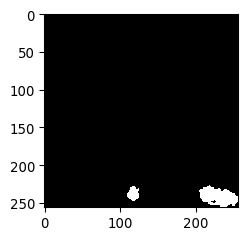

Predicao com Ajuste por elipse: 


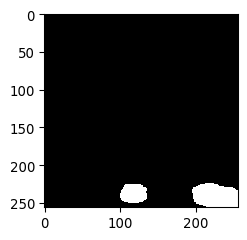

Acurácia:  0.875 , Indice de Jaccard : 0.3335 Coef de Dice 0.5002
--------------------------------------------------------------------------------------------------
Imagem RGB:


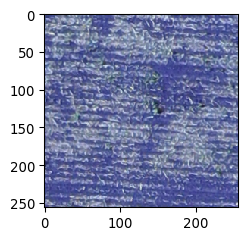

Referencia: 


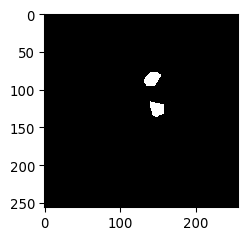

Predicao : 


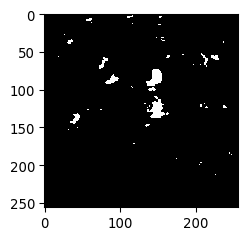

Predicao limpa com superpixels :


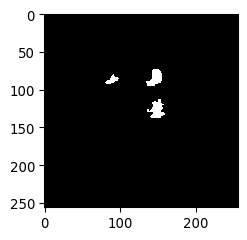

Predicao com Ajuste por elipse: 


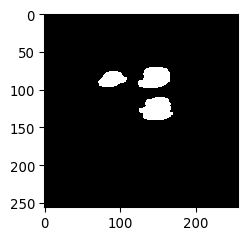

Acurácia:  0.7734375 , Indice de Jaccard : 0.234 Coef de Dice 0.3792
--------------------------------------------------------------------------------------------------
Imagem RGB:


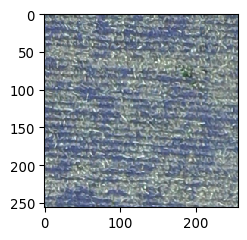

Referencia: 


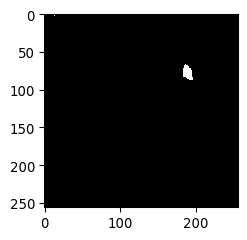

Predicao : 


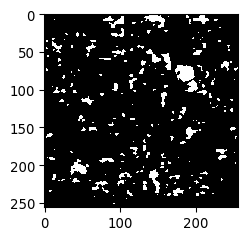

Predicao limpa com superpixels :


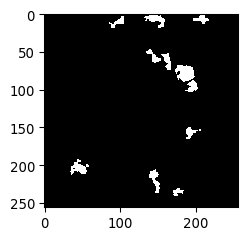

Predicao com Ajuste por elipse: 


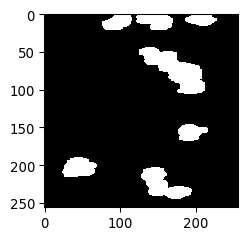

Acurácia:  0.3671875 , Indice de Jaccard : 0.0238 Coef de Dice 0.0466
--------------------------------------------------------------------------------------------------
Imagem RGB:


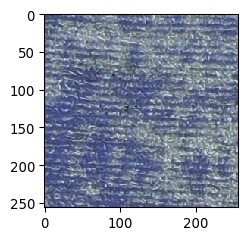

Referencia: 


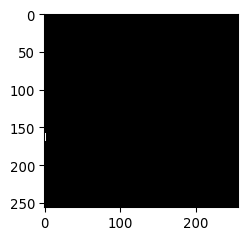

Predicao : 


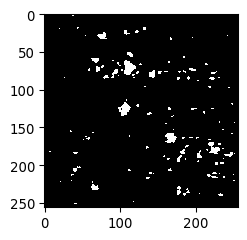

Predicao limpa com superpixels :


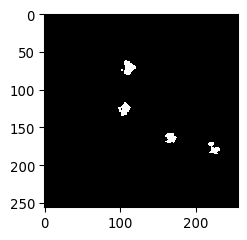

Predicao com Ajuste por elipse: 


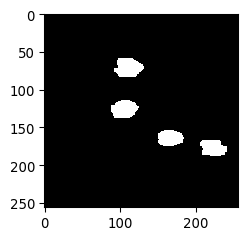

Acurácia:  0.671875 , Indice de Jaccard : 0.0 Coef de Dice 0.0
--------------------------------------------------------------------------------------------------
iou :  0.101 , dice : 0.16851999999999998 , Recall :  0.770641990197509 , acc : 0.638671875 



In [18]:
diretorio_rgb = "../../daninhas/ortomosaicos/pre-emergente/190837/rgb/"
diretorio_true = "../../daninhas/ortomosaicos/pre-emergente/190837/marcacoes_manuais/"
diretorio_pred = "../../daninhas/ortomosaicos/pre-emergente/190837/resultados_rede_manuais/"

count = 0
num_images = len(os.listdir(diretorio_pred))

c1 = 0
c2 = 0
c3 = 0
c5 = 0

for name in os.listdir(diretorio_pred): 
    count += 1
    if count > 10:
        break
    print('Imagem RGB:')
    img_rgb = cv2.imread(diretorio_rgb + name, 1)
    iaa.imshow(img_rgb)
    
    img_true =  cv2.imread(diretorio_true + name)
    img_true = cv2.cvtColor(img_true, cv2.COLOR_BGR2GRAY)
    print('Referencia: ')
    iaa.imshow(img_true)
    
    img_pred =  cv2.imread(diretorio_pred + name)
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2GRAY)
    print('Predicao : ')
    iaa.imshow(img_pred)
    print('Predicao limpa com superpixels :')
    img_pred = adjust_pixels(img_pred, 100) #Funcao paraa eliminar os pixels menores    
    #img_pred = cv2.resize(img_pred,(512,512))
    coordinates_pixels_white = np.column_stack(np.where(img_pred != [0]))
    iaa.imshow(img_pred)
    for i in range(0, len(coordinates_pixels_white), 1):
        #print(coordinates_pixels_white[i])
        img_pred = ellipse_overlap(img_pred, coordinates_pixels_white[i][0], coordinates_pixels_white[i][1], 10, 3, 0)

    print('Predicao com Ajuste por elipse: ')
    iaa.imshow(img_pred)

    #uip_c, IoU_c, dice_c, dice_c2 = metrics_seg(img_pred, img_true)
    
    vl_jac = round(metrics.jaccard_score(img_pred, img_true, average='micro'), 4) #iou
    vl_dic = round(dice(img_pred, img_true), 4)
    vl_acc = metrics.accuracy_score(img_pred, img_true)
    vl_prc = metrics.precision_score(img_pred, img_true, average='micro')
    
    c1 += vl_acc
    c2 += vl_jac
    c3 += vl_prc
    c5 += vl_dic
    
    print('Acurácia: ', vl_acc, ', Indice de Jaccard :', vl_jac, 'Coef de Dice', vl_dic)
    print('--------------------------------------------------------------------------------------------------')
    
print('iou : ', c2 / (count -1), ', dice :', c5 / (count -1),', Recall : ', c3 / (count -1), ', acc :', c1 / (count -1), '\n')